Verificaremos a liquidez das BDR's, o código abaixo foi desenvolvido pela Quant-Brazil. Estou repoduzindo para fins educacionais e claro tentando entender mais como funciona Python na questão de análise de dados. Gosto de dados, python e mais ainda do mercado financeiro mais em específico do mercado de renda variável. Agradecimento total a Quant-Brazil por possibilitar apreendizado para nós iniciantes.

In [16]:
import pandas as pd 
import numpy as np 
 #Biblioteca de visualização de dados
import matplotlib.pyplot as plt

#Biblioteca para conectar e converter python em sql
from sqlalchemy import create_engine
!pip install psycopg2-binary
import psycopg2

# Biblioteca para manipular diretórios
import os

# Biblioteca para obter dados de ações do Yahoo! Finança
!pip install -q yfinance
import yfinance as yf

# Biblioteca HTTP
import requests

# Utilizaremos a função requests.get() para fazer a requisição da url
url = "https://investnews.com.br/financas/veja-a-lista-completa-dos-bdrs-disponiveis-para-pessoas-fisicas-na-b3/"
r = requests.get(url)
html = r.text
df = pd.read_html(html, header=0)[0]

df.head()

#O ticker das BDRs geralmente apresentam o sufixo 34 
#(menos frequentemente 35). Vamos checar essa informação através da função str.endswith do pandas. 
filter = ~(df["CÓDIGO"].str.endswith('34'))
df[filter]

#Vamos corrigi-los utilizando novamente um filtro, dessa vez buscando pelos valores 
#incorretos e substituindo-os pelo valor correto.

filter = df["CÓDIGO"] == "E1XC34monde"
df["CÓDIGO"][filter] = "E1XC34"
df[filter]

filter = df["CÓDIGO"] == "INGG3"
df["CÓDIGO"][filter] = "INGG34"
df[filter]
#Pronto! Acabamos de fazer o que chamamos de data cleasing no âmbito do Data Science.

#Os tickers serão os valores da coluna YF_CÓDIGO no formato de lista. Baixaremos os dados de uma janela de 2 meses (2mo).


bdr = df.loc[:,["EMPRESA", "CÓDIGO"]].copy()
bdr["YF_CÓDIGO"] = bdr["CÓDIGO"] + ".SA"
bdr

tickers = list(bdr["YF_CÓDIGO"])
df = yf.download(tickers, period='2mo').copy()['Volume']
df.drop(columns=["C1HL34.SA", "TIFF34.SA", "V1AR34.SA", "C1EO34.SA", "C1XO34.SA", "U1NL34.SA"], inplace=True)

[*********************100%***********************]  673 of 673 completed

6 Failed downloads:
- C1HL34.SA: No data found, symbol may be delisted
- C1XO34.SA: No data found, symbol may be delisted
- V1AR34.SA: No data found, symbol may be delisted
- C1EO34.SA: No data found, symbol may be delisted
- TIFF34.SA: No data found, symbol may be delisted
- U1NL34.SA: No data found, symbol may be delisted


In [19]:
df.isnull().any().sum()
#Faremos isso através da função interpolate do pandas.
df.interpolate(inplace=True)

#A fim de calcular a média móvel de 21 dias para cada um dos ativos, 
#vamos iterar sobre cada coluna do nosso dataframe. Adicionaremos essas informações a um novo dataframe: mm21.
mm21 = pd.DataFrame()

for column in df.columns: 
    mm21[column] = df[column].rolling(21).mean()

mm21 = mm21[20:]
mm21.head()

#O próximo passo é selecionar os valores da última linha (que são os valores atuais) 
#e ordená-los através da função sort_values em ordem decrescente (ascending=False).

sorted_mm21 = mm21.iloc[-1].sort_values(ascending=False)
sorted_mm21


MELI34.SA    511825.111111
TSLA34.SA    346158.412698
NVDC34.SA    252382.380952
BABA34.SA    222303.063492
RIGG34.SA    197416.888889
                 ...      
O1DF34.SA         0.000000
M1CK34.SA         0.000000
M1LM34.SA         0.000000
AWII34.SA         0.000000
L1YG34.SA              NaN
Name: 2021-07-22 00:00:00, Length: 667, dtype: float64

Text(0.5, 1.0, 'As 15 BDRs de Mais Negociadas da Bolsa de Valores Brasileira')

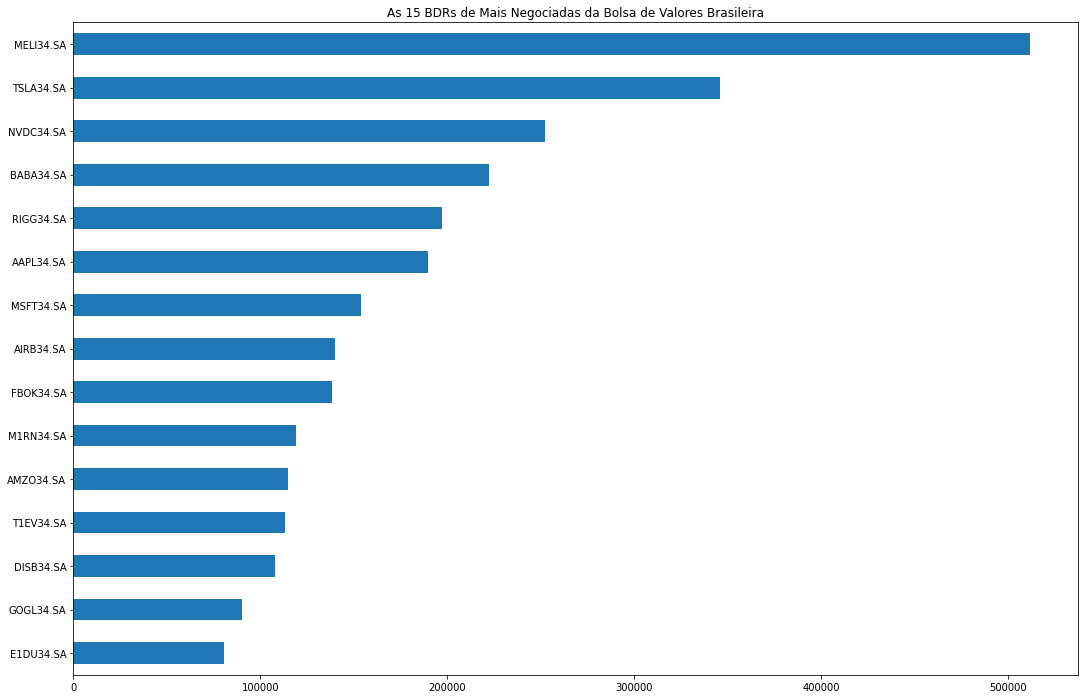

In [20]:
#Pronto! Agora vamos plotar as 15 BDRs (top_15_bdr) mais líquidas em um gráfico de barras horizontais (barh) através da função plot do matplotlib.

fig = plt.figure(figsize=(18,12))
top_15_bdr = sorted_mm21[:15]
ax = top_15_bdr.plot(kind='barh')
ax.invert_yaxis()
ax.set_title("As 15 BDRs de Mais Negociadas da Bolsa de Valores Brasileira")


[*********************100%***********************]  3 of 3 completed


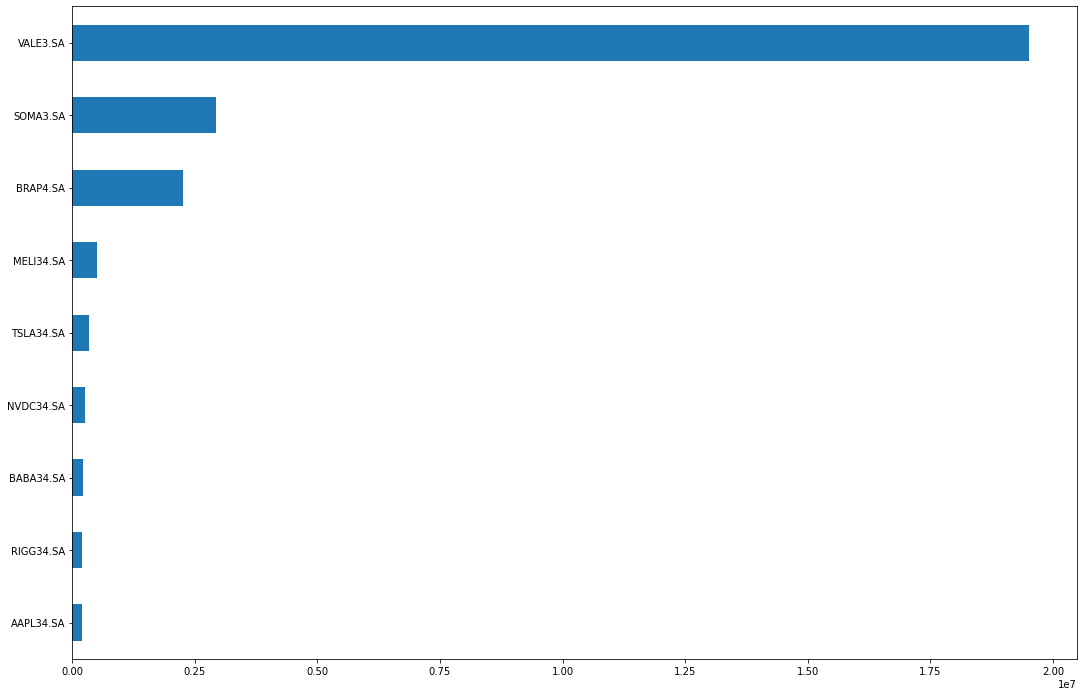

In [27]:
df = yf.download(["VALE3.SA", "BRAP4.SA", "SOMA3.SA"], period='2mo').copy()["Volume"]
df.interpolate(inplace=True)
mm21 = pd.DataFrame()

for column in df.columns: 
    mm21[column] = df[column].rolling(21).mean()

#Com as médias móveis calculadas, basta juntar a última linha (mm21.iloc[-1]]) com as duas BDRs 
#mais líquidas (top_15_bdr[:2]), ordená-las e enfim, plotá-las novamente em um gráfico de barras horizontais.

liquidity_analysis = pd.concat([top_15_bdr[:6], mm21.iloc[-1]])
liquidity_analysis =  liquidity_analysis.sort_values(ascending=False)
fig = plt.figure(figsize=(18,12))
ax = liquidity_analysis.plot(kind='barh')
ax.invert_yaxis()